# Calculating functional and taxonomic diversity of transporters

## Overview

Here we will use the [Shannon diversity index](https://en.wikipedia.org/wiki/Diversity_index) to calculate both taxonomic diversity of transporters and functional diversity of most abundant taxa in each sample.

In [31]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, wilcoxon
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [32]:
def filter_low_abundance(df, f=0.5):
    # Calculate mean abundance of transporters
    df_trans_mean = df.groupby(["fam","transporter"]).sum().reset_index().groupby(["transporter"]).mean()
    # Normalize to percent
    n = df_trans_mean.div(df_trans_mean.sum())*100
    # Filter to those with max % >= to the threshold
    n = n.loc[n.max(axis=1)>=f]
    return set(n.index)

In [33]:
def shannon_proportions(counts,base=2):
    '''Modified version of shannon to handle proportions instead of absolute counts.'''
    # Generate list of floats
    counts = [float(item) for item in counts]
    counts = np.asarray(counts)
    if counts.sum()==0: return -1,0
    # frequencies are 
    freqs = counts / counts.sum()
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum() / np.log(base),len(nonzero_freqs)

In [34]:
def transporter_taxonomic_diversity(df,ranks,transporters,data_type,taxa):
    data = pd.DataFrame(columns=["rank","sample","transporter","dataset","taxa","diversity","num_taxa"])
    index = -1
    for rank in ranks:
        # Sum to abundance per family for each rank
        tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
        # Get mean transporter abundance for each rank
        tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
        samples = tmp_mean.columns[2:]
        for transporter in transporters:
            # Get transporter data
            tmp_trans = tmp_mean.loc[tmp_mean.transporter==transporter] 
            # Sum for the current rank and transporter
            tmp_trans_rank = tmp_trans.groupby(rank).sum() 
            # Normalize to % in each sample
            tmp_trans_rank_norm = tmp_trans_rank.div(tmp_trans_rank.sum())*100
            # Fill gaps
            tmp_trans_rank_norm.fillna(0,inplace=True)
            # For each sample, calculate diversity and number of taxa for this transporter
            for sample in samples:
                div,num_taxa = shannon_proportions(tmp_trans_rank_norm[sample])
                index+=1
                df_tmp = pd.DataFrame(index=[index],data={"rank":rank,"taxa":taxa,"dataset":data_type,"sample":sample,"transporter":transporter,"diversity":div,"num_taxa":num_taxa})
                data = pd.concat([data,df_tmp])
    return data

In [35]:
def taxonomic_functional_diversity(df,rank,data_type,t_quantile=0.9):
    # Create empty dataframe
    data = pd.DataFrame(columns=["taxa","sample","type","diversity","num_transporters"])
    # Sum to abundance per family for each rank
    tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
    # Get mean transporter abundance for each rank
    tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
    # Get total transporter abundance for each rank (sum over all transporters)
    # Also remove unclassified orders and environmental samples
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("unclassified", case=False)]
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("environmental samples", case=False)]
    tmp_trans_tax_sum = tmp_mean.groupby(rank).sum()    
    samples = tmp_mean.columns[2:]
    index=-1
    for sample in samples:
        # Calculate taxa that make up the quantiles for the transporter data
        q_trans_taxa = list(tmp_trans_tax_sum.loc[tmp_trans_tax_sum[sample]>tmp_trans_tax_sum[sample].quantile(q=t_quantile)].index)
        sample_taxa = q_trans_taxa
        for tax in sample_taxa:
            # Get tax data
            tmp_tax_trans = tmp_mean.loc[tmp_mean[rank]==tax,sample] 
            # Normalize
            tmp_tax_trans_norm = tmp_tax_trans.div(tmp_tax_trans.sum())*100
            # Calculate diversity and number of transporters for this order in this sample
            div,num_transporters = shannon_proportions(tmp_tax_trans_norm)
            index+=1
            # Add to dataframe
            df_tmp = pd.DataFrame(index=[index],data={"taxa":tax,"type":data_type,"sample":sample,"diversity":div,"num_transporters":num_transporters})
            data = pd.concat([data,df_tmp])
    taxsort = list(tmp_trans_tax_sum.loc[list(set(data.taxa))].mean(axis=1).sort_values(ascending=False).index)
    return data,taxsort

## Read sample groups

In [36]:
mg_groups = pd.read_csv("results/mg/samplegroups.tab", index_col=0, sep="\t")
mg_groups.rename(index=lambda x: str(x), inplace=True)

In [37]:
mt_groups = pd.read_csv("results/mt/samplegroups.tab", index_col=0, sep="\t")
mt_groups.rename(index=lambda x: str(x), inplace=True)

## Read transporter/taxonomic data

In [38]:
mg_taxcov = pd.read_table("results/mg/select_trans_genes.tpm.tsv", index_col=0)
mt_taxcov = pd.read_table("results/mt/select_trans_genes.tpm.tsv", index_col=0)

mg_all_taxcov = pd.read_table("results/mg/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)
mt_all_taxcov = pd.read_table("results/mt/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)

mg_all_taxraw = pd.read_table("results/mg/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)
mt_all_taxraw = pd.read_table("results/mt/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)

Filter low abundant transporters.

In [39]:
f = 0.5
mg_filtered = filter_low_abundance(mg_all_taxcov, f=f)
mt_filtered = filter_low_abundance(mt_all_taxcov, f=f)
all_filtered = list(mg_filtered.union(mt_filtered))
print("{} and {} ({} total) transporters with max % >= {} in the metagenomes and metatranscriptomes, respectively.".format(len(mg_filtered), len(mt_filtered), len(all_filtered), f))

81 and 84 (99 total) transporters with max % >= 0.5 in the metagenomes and metatranscriptomes, respectively.


In [40]:
mg_all_taxcov = mg_all_taxcov.loc[mg_all_taxcov.transporter.isin(all_filtered)]
mt_all_taxcov = mt_all_taxcov.loc[mt_all_taxcov.transporter.isin(all_filtered)]

In [41]:
mg_filtered_taxraw = mg_all_taxraw.loc[mg_all_taxraw.transporter.isin(all_filtered)]
mt_filtered_taxraw = mt_all_taxraw.loc[mt_all_taxraw.transporter.isin(all_filtered)]

Filter out orders to those that have at least 500 reads mapped on average across the datasets.

In [42]:
mg_filtered_taxraw_ordermean = mg_filtered_taxraw.groupby("order").sum().mean(axis=1)
mg_filtered_orders = mg_filtered_taxraw_ordermean.loc[(mg_filtered_taxraw_ordermean>=500)&(~mg_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
print("\n".join(["{}: {} average reads".format(x,np.round(mg_filtered_taxraw_ordermean.loc[x],0)) for x in mg_filtered_orders]))

Flavobacteriales: 5413.0 average reads
Sphingobacteriales: 2626.0 average reads
Pelagibacterales: 1584.0 average reads
Cellvibrionales: 1530.0 average reads
Rhodobacterales: 998.0 average reads
Burkholderiales: 600.0 average reads
Opitutales: 592.0 average reads
Mamiellales: 546.0 average reads


In [43]:
mt_filtered_taxraw_ordermean = mt_filtered_taxraw.groupby("order").sum().mean(axis=1)
mt_filtered_orders = mt_filtered_taxraw_ordermean.loc[(mt_filtered_taxraw_ordermean>=500)&(~mt_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
list(mt_filtered_orders)
print("\n".join(["{}: {} average reads".format(x,np.round(mt_filtered_taxraw_ordermean.loc[x],0)) for x in mt_filtered_orders]))

Flavobacteriales: 5976.0 average reads
Mamiellales: 1366.0 average reads
Cellvibrionales: 776.0 average reads
Sphingobacteriales: 613.0 average reads


Read information on transporters.

In [44]:
transinfo = pd.read_csv("selected_transporters_classified.tab", index_col=0, header=0, sep="\t")

In [45]:
categories = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]

In [46]:
genera = mg_all_taxcov.loc[(mg_all_taxcov.transporter.isin(transinfo.index))&(mg_all_taxcov["order"].isin(mg_filtered_orders)),"genus"].unique()
len([x for x in genera if not "Unclassified" in x])

31

Calculate functional diversity per sample for taxa at rank order. **For each sample, only consider taxa that are part of the upper 90% quantile.** This will hopefully make the functional diversity estimates more reliable.

In [47]:
mg_tax_fun_div,mg_taxsort = taxonomic_functional_diversity(mg_taxcov,rank="order",t_quantile=0.9,data_type="mg")

In [48]:
coldict = dict(zip(set(mg_filtered_orders).union(mt_filtered_orders),sns.color_palette("Set2", n_colors=len(set(mg_filtered_orders).union(mt_filtered_orders)))))

ValueError: Invalid RGBA argument: masked

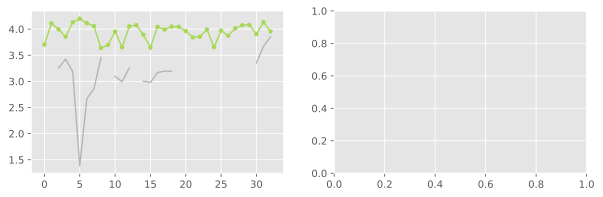

In [22]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_filtered_orders)],y="diversity",x="sample",hue="taxa",
                    scale=0.5, ax=axes[0],palette=coldict, hue_order=mg_filtered_orders)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_ylabel("Transporter diversity", fontsize=10)

ax2 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_filtered_orders)],y="num_transporters",x="sample",hue="taxa",
                    scale=0.5, ax=axes[1],palette=coldict, hue_order=mg_filtered_orders)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_ylabel("Number of transporters", fontsize=10)

plt.savefig("results/Figure4.svg", bbox_inches="tight")

In [23]:
mt_tax_fun_div,mt_taxsort = taxonomic_functional_diversity(mt_taxcov,rank="order",t_quantile=0.9,data_type="mt")

ValueError: Invalid RGBA argument: masked

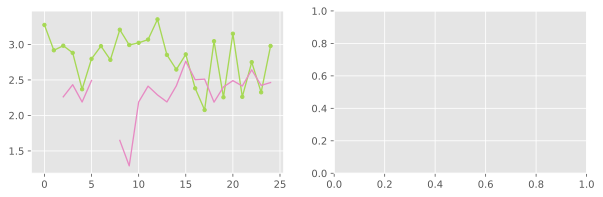

In [24]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_filtered_orders)],y="diversity",x="sample",hue="taxa",
                    scale=0.5, ax=axes[0],palette=coldict, hue_order=mt_filtered_orders)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_ylabel("Transporter diversity", fontsize=10)

ax2 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_filtered_orders)],y="num_transporters",x="sample",hue="taxa",
                    scale=0.5, ax=axes[1],palette=coldict, hue_order=mt_filtered_orders)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_ylabel("Number of transporters", fontsize=10)

## Calculate profiles for rank order

In [25]:
# Sum to protein family
mg_order_famsum = mg_taxcov.groupby(["fam","transporter","order"]).sum().reset_index()
# Take mean of transporter
mg_order_transmean = mg_order_famsum.groupby(["transporter","order"]).mean().reset_index()
# Add substrate categories
mg_order_transmean = pd.merge(transinfo, mg_order_transmean, left_index=True, right_on="transporter")

In [26]:
# Sum to protein family
mt_order_famsum = mt_taxcov.groupby(["fam","transporter","order"]).sum().reset_index()
# Take mean of transporter
mt_order_transmean = mt_order_famsum.groupby(["transporter","order"]).mean().reset_index()
# Add substrate categories
mt_order_transmean = pd.merge(transinfo, mt_order_transmean, left_index=True, right_on="transporter")

In [27]:
cats = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]

In [28]:
mg_orders = ["Pelagibacterales","Flavobacteriales","Cellvibrionales","Rhodobacterales"]
mg_substrates = ["AA peptide + (NH4+)","Anions","Carbohydrate","Cations","Phosphate","Nitrate","Metal","Urea","Phosphonate"]
mt_substrates = ["AA peptide + (NH4+)","Anions","Carbohydrate","Cations","Phosphate","Nitrate","Metal","Urea","Phosphonate"]

In [29]:
cat_cols = sns.color_palette("Paired", 6) + sns.color_palette("Dark2",4)[1:]
cat_lut = dict(zip(map(str,cats),cat_cols))
cat_lut["Other"] = "black"

KeyError: 'Carbohydrate'

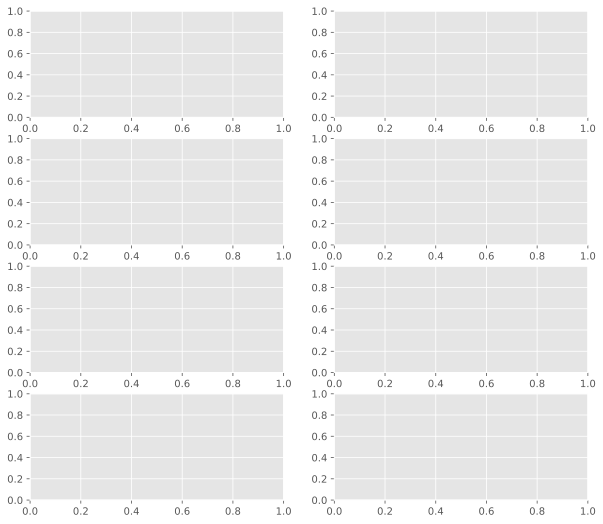

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(10,9))
all_axes = list(axes[0])+list(axes[1])+list(axes[2])+list(axes[3])

substrates = []
for i, o in enumerate(mg_filtered_orders):
    _df = mg_order_transmean.loc[mg_order_transmean["order"]==o].groupby("substrate_category").sum()
    _df = _df.loc[set(mg_substrates).intersection(_df.index)]
    substrates+=list(_df.index)
    ax = _df.T.plot(kind="bar",stacked=True,ax=all_axes[i], legend=None, color=[cat_lut[x] for x in _df.index])
    if i in [0,2,4,6]:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    if i in [6,7]:
        ax.set_xlabel("Date", fontsize=10)
    ax.set_title(o, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.subplots_adjust(hspace=0.7, wspace=0.12)
# Add legend
handles = [mpatches.Patch(color=cat_lut[substrate], label=substrate) for substrate in sorted(set(substrates))]
all_axes[3].legend(handles=handles, bbox_to_anchor=(1,1))
plt.savefig("results/Figure5A.svg", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(10,9))
all_axes = list(axes[0])+list(axes[1])+list(axes[2])+list(axes[3])

substrates = []
for i, o in enumerate(mg_filtered_orders):
    _df = mg_order_transmean.loc[mg_order_transmean["order"]==o].groupby("substrate_category").sum()
    _df = _df.loc[set(mg_substrates).intersection(_df.index)]
    _df = _df.div(_df.sum())*100
    substrates+=list(_df.index)
    ax = _df.T.plot(kind="bar",stacked=True,ax=all_axes[i], legend=None, color=[cat_lut[x] for x in _df.index])
    if i in [0,2,4,6]:
        ax.set_ylabel("% of transporters\nfor taxa", fontsize=10)
    if i in [6,7]:
        ax.set_xlabel("Date", fontsize=10)
    ax.set_title(o, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.subplots_adjust(hspace=0.7, wspace=0.12)
# Add legend
handles = [mpatches.Patch(color=cat_lut[substrate], label=substrate) for substrate in sorted(set(substrates))]
all_axes[3].legend(handles=handles, bbox_to_anchor=(1,1))
plt.savefig("results/Figure5B.svg", bbox_inches="tight")

In [ ]:
def view_mean(df, order):
    _ = df.loc[df["order"]==order].groupby("substrate_category").sum()
    _ = _.div(_.sum())*100
    return _.mean(axis=1).sort_values(ascending=False)
view_mean(df=mg_order_transmean,order="Cellvibrionales")

Metatranscriptomes.

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,4.5))
all_axes = list(axes[0])+list(axes[1])

substrates = []
for i, o in enumerate(mt_filtered_orders):
    _df = mt_order_transmean.loc[mt_order_transmean["order"]==o].groupby("substrate_category").sum()
    _df = _df.loc[set(mt_substrates).intersection(_df.index)]
    substrates+=list(_df.index)
    ax = _df.T.plot(kind="bar",stacked=True,ax=all_axes[i], legend=None, color=[cat_lut[x] for x in _df.index])
    if i in [0,2,4,6]:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    if i in [6,7]:
        ax.set_xlabel("Date", fontsize=10)
    ax.set_title(o, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.subplots_adjust(hspace=0.7, wspace=0.12)
# Add legend
handles = [mpatches.Patch(color=cat_lut[substrate], label=substrate) for substrate in sorted(set(substrates))]
all_axes[3].legend(handles=handles, bbox_to_anchor=(1,1))

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,4.5))
all_axes = list(axes[0])+list(axes[1])

substrates = []
for i, o in enumerate(mt_filtered_orders):
    _df = mt_order_transmean.loc[mt_order_transmean["order"]==o].groupby("substrate_category").sum()
    _df = _df.loc[set(mt_substrates).intersection(_df.index)]
    _df = _df.div(_df.sum())*100
    substrates+=list(_df.index)
    ax = _df.T.plot(kind="bar",stacked=True,ax=all_axes[i], legend=None, color=[cat_lut[x] for x in _df.index])
    if i in [0,2,4,6]:
        ax.set_ylabel("% of transporters\nfor taxa", fontsize=10)
    if i in [6,7]:
        ax.set_xlabel("Date", fontsize=10)
    ax.set_title(o, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.subplots_adjust(hspace=0.7, wspace=0.12)
# Add legend
handles = [mpatches.Patch(color=cat_lut[substrate], label=substrate) for substrate in sorted(set(substrates))]
all_axes[3].legend(handles=handles, bbox_to_anchor=(1,1))

### Correlations for shared dates

Here we correlate abundance of transporters in the metagenomic vs. metatranscriptomic data for dates found with both datasets. We compare abundances for the overlapping dates and for the 4 filtered orders that have >500 reads mapped on average in both datasets.

In [ ]:
common_dates = sorted(list(set(mg_order_transmean.columns[6:]).intersection(set(mt_order_transmean.columns[6:]))))
common_orders = ["Flavobacteriales", "Mamiellales", "Cellvibrionales", "Sphingobacteriales"]

In [ ]:
def df_sum(df, order, dates):
    x = df.loc[df.order==order].groupby("substrate_category").sum().loc[:,dates]
    x = x.loc[x.sum(axis=1)>0]
    return x

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
all_axes = [x[i] for x in axes for i in [0,1]]
cor_df = pd.DataFrame()
substrates = []
for i, order in enumerate(common_orders):
    ax = all_axes[i]
    # Sum by substrate category for each order in both datasets
    x = df_sum(mg_order_transmean, order, common_dates)
    y = df_sum(mt_order_transmean, order, common_dates)
    # Standardize the data
    xt = x.T
    xt = (xt - xt.mean()) / xt.std()
    yt = y.T
    yt = (yt - yt.mean()) / yt.std()
    # Correlate
    c = xt.corrwith(yt, drop=True)
    patches = []
    temp = pd.merge(xt.T,yt.T,left_index=True,right_index=True, suffixes=["_mg","_mt"])
    temp = temp.assign(Order=pd.Series(order, index=temp.index))
    cor_df = pd.concat([cor_df,temp])
    for cat in (set(xt.columns).intersection(yt.columns)).intersection(cats):
        substrates.append(cat)
        color = cat_lut[cat]
        label = "{} ({})".format(cat, np.round(c.loc[cat], 2))
        patches.append(mpatches.Patch(color=color, label=label))
        axis = pd.merge(xt, yt, right_index=True, left_index=True, 
             suffixes=["_mg","_mt"]).plot.scatter(x="{}_mg".format(cat), y="{}_mt".format(cat), color=cat_lut[cat], ax=ax)
    ax.legend(handles=patches, bbox_to_anchor=(1,1), fontsize="8")
    ax.set_ylabel("Standardized MT")
    ax.set_xlabel("Standardized MG")
    ax.set_title(order, fontsize=10)
plt.subplots_adjust(hspace=0.4, wspace=1.2)
plt.savefig("results/Figure8A.svg", bbox_inches="tight")

In [ ]:
cor_df.to_csv("results/abundant_orders_standardized.tab", sep="\t")

## Calculate diversity per transporter and rank.

Calculate for different subsets.

In [ ]:
ranks = ["order"]
mg_trans_div = transporter_taxonomic_diversity(mg_taxcov,ranks,list(set(mg_taxcov.transporter)),"mg","all")
mg_trans_div_bac = transporter_taxonomic_diversity(mg_taxcov.loc[(mg_taxcov.superkingdom=="Bacteria")&(mg_taxcov.phylum!="Cyanobacteria")],ranks,list(set(mg_taxcov.transporter)),"mg","Bacteria")
mg_trans_div_euk = transporter_taxonomic_diversity(mg_taxcov.loc[mg_taxcov.superkingdom=="Eukaryota"],ranks,list(set(mg_taxcov.transporter)),"mg","Eukaryota")
mg_trans_div_cya = transporter_taxonomic_diversity(mg_taxcov.loc[mg_taxcov.phylum=="Cyanobacteria"],ranks,list(set(mg_taxcov.transporter)),"mg","Cyanobacteria")

In [ ]:
ranks = ["order"]
mt_trans_div = transporter_taxonomic_diversity(mt_taxcov,ranks,list(set(mt_taxcov.transporter)),"mt","all")
mt_trans_div_bac = transporter_taxonomic_diversity(mt_taxcov.loc[(mt_taxcov.superkingdom=="Bacteria")&(mt_taxcov.phylum!="Cyanobacteria")],ranks,list(set(mt_taxcov.transporter)),"mt","Bacteria")
mt_trans_div_euk = transporter_taxonomic_diversity(mt_taxcov.loc[mt_taxcov.superkingdom=="Eukaryota"],ranks,list(set(mt_taxcov.transporter)),"mt","Eukaryota")
mt_trans_div_cya = transporter_taxonomic_diversity(mt_taxcov.loc[mt_taxcov.phylum=="Cyanobacteria"],ranks,list(set(mt_taxcov.transporter)),"mt","Cyanobacteria")

Combine dataframes.

In [ ]:
transporter_diversity = pd.concat([mg_trans_div,mg_trans_div_bac])
transporter_diversity = pd.concat([transporter_diversity,mg_trans_div_euk])
transporter_diversity = pd.concat([transporter_diversity,mg_trans_div_cya])

In [ ]:
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_bac])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_euk])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_cya])

Merge with transporter info.

In [ ]:
transporter_diversity = pd.merge(transporter_diversity,transinfo,left_on="transporter",right_index=True)

In [ ]:
transporter_diversity.to_csv("results/transporter_diversity.tab", sep="\t")

In [ ]:
transporter_diversity.sample(5)

### Plot bars for each category, by taxa and dataset

In [ ]:
transporter_diversity.loc[transporter_diversity.dataset=="mg","dataset"] = "MG"
transporter_diversity.loc[transporter_diversity.dataset=="mt","dataset"] = "MT"

In [ ]:
transporter_diversity.loc[transporter_diversity.taxa=="Eukaryota","taxa"] = "Picoeukaryota"

In [ ]:
ax = sns.catplot(data=transporter_diversity.loc[transporter_diversity.diversity>=0],
                    height=3, col_order = ["Bacteria","Picoeukaryota","Cyanobacteria"],x="diversity",y="substrate_category",hue="dataset",col="taxa",
                 kind="bar",aspect=1,order=sorted(list(set(transporter_diversity.substrate_category))),errwidth=1)
ax.set_titles("{col_name}");
ax.axes[0][0].set_ylabel("Substrate category", fontsize=10)
ax.axes[0][0].set_xlabel("Diversity", fontsize=10)

In [ ]:
sns.set(font_scale=0.8)
ax = sns.catplot(data=transporter_diversity.loc[transporter_diversity.diversity>=0],
                    height=3, col_order = ["Bacteria","Picoeukaryota","Cyanobacteria"],
                 x="num_taxa",y="substrate_category",hue="dataset",col="taxa",kind="bar",palette="Set1",
                 aspect=1,order=sorted(list(set(transporter_diversity.substrate_category))),errwidth=1)
ax.set_titles("{col_name}");
axis = ax.axes[0]
for i, a in enumerate(axis):
    a.set_xlabel("Orders");
    if i==0:
        a.set_ylabel("Substrate category")
plt.savefig("results/Figure3B.svg", bbox_inches="tight")

## Plot profiles for select transporter substrates

Generate transporter means in each taxgroup.

In [ ]:
mg_df = mg_all_taxcov.copy(deep=True)
mt_df = mt_all_taxcov.copy(deep=True)

In [ ]:
mg_bac_sum = mg_df.loc[(mg_df.superkingdom=="Bacteria")&(mg_df.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mg_bac_mean = mg_bac_sum.groupby("transporter").mean()
mg_bac_meanp = mg_bac_mean.div(mg_bac_mean.sum())*100
mg_bac_meanp = pd.merge(transinfo,mg_bac_meanp,left_index=True, right_index=True)
mg_bac_melt = pd.melt(mg_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mg_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_bac_melt = mg_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mg_bac_melt)))

In [ ]:
mg_arc_sum = mg_df.loc[(mg_df.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum().reset_index()
mg_arc_mean = mg_arc_sum.groupby("transporter").mean()
mg_arc_meanp = mg_arc_mean.div(mg_arc_mean.sum())*100
mg_arc_meanp = pd.merge(transinfo,mg_arc_meanp,left_index=True, right_index=True)
mg_arc_melt = pd.melt(mg_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mg_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_arc_melt = mg_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mg_arc_melt)))

In [ ]:
mg_cya_sum = mg_df.loc[(mg_df.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mg_cya_mean = mg_cya_sum.groupby("transporter").mean()
mg_cya_meanp = mg_cya_mean.div(mg_cya_mean.sum())*100
mg_cya_meanp = pd.merge(transinfo,mg_cya_meanp,left_index=True, right_index=True)
mg_cya_melt = pd.melt(mg_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mg_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_cya_melt = mg_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mg_cya_melt)))

In [ ]:
mg_euk_sum = mg_df.loc[(mg_df.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum().reset_index()
mg_euk_mean = mg_euk_sum.groupby("transporter").mean()
mg_euk_meanp = mg_euk_mean.div(mg_euk_mean.sum())*100
mg_euk_meanp = pd.merge(transinfo,mg_euk_meanp,left_index=True, right_index=True)
mg_euk_melt = pd.melt(mg_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mg_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_euk_melt = mg_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mg_euk_melt)))

In [ ]:
mg_melt = pd.concat([mg_bac_melt,mg_cya_melt])
mg_melt = pd.concat([mg_melt,mg_arc_melt])
mg_melt = pd.concat([mg_melt,mg_euk_melt])

In [ ]:
mt_bac_sum = mt_df.loc[(mt_df.superkingdom=="Bacteria")&(mt_df.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mt_bac_mean = mt_bac_sum.groupby("transporter").mean()
mt_bac_meanp = mt_bac_mean.div(mt_bac_mean.sum())*100
mt_bac_meanp = pd.merge(transinfo,mt_bac_meanp,left_index=True, right_index=True)
mt_bac_melt = pd.melt(mt_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mt_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_bac_melt = mt_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mt_bac_melt)))

In [ ]:
mt_arc_sum = mt_df.loc[(mt_df.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum().reset_index()
mt_arc_mean = mt_arc_sum.groupby("transporter").mean()
mt_arc_meanp = mt_arc_mean.div(mt_arc_mean.sum())*100
mt_arc_meanp = pd.merge(transinfo,mt_arc_meanp,left_index=True, right_index=True)
mt_arc_melt = pd.melt(mt_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mt_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_arc_melt = mt_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mt_arc_melt)))

In [ ]:
mt_cya_sum = mt_df.loc[(mt_df.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mt_cya_mean = mt_cya_sum.groupby("transporter").mean()
mt_cya_meanp = mt_cya_mean.div(mt_cya_mean.sum())*100
mt_cya_meanp = pd.merge(transinfo,mt_cya_meanp,left_index=True, right_index=True)
mt_cya_melt = pd.melt(mt_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mt_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_cya_melt = mt_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mt_cya_melt)))

In [ ]:
mt_euk_sum = mt_df.loc[(mt_df.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum().reset_index()
mt_euk_mean = mt_euk_sum.groupby("transporter").mean()
mt_euk_meanp = mt_euk_mean.div(mt_euk_mean.sum())*100
mt_euk_meanp = pd.merge(transinfo,mt_euk_meanp,left_index=True, right_index=True)
mt_euk_melt = pd.melt(mt_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mt_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_euk_melt = mt_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mt_euk_melt)))

In [ ]:
mt_melt = pd.concat([mt_bac_melt,mt_cya_melt])
mt_melt = pd.concat([mt_melt,mt_arc_melt])
mt_melt = pd.concat([mt_melt,mt_euk_melt])

Show contribution of different taxgroups to total transporters.

In [ ]:
b = pd.DataFrame(mg_bac_mean.sum(), columns=["Bac"])
c = pd.DataFrame(mg_cya_mean.sum(), columns=["Cya"])
e = pd.DataFrame(mg_euk_mean.sum(), columns=["Euk"])
bce = pd.concat([e,pd.concat([b,c],axis=1)],axis=1)
bce.sum().div(bce.sum().sum())*100

In [ ]:
b = pd.DataFrame(mt_bac_mean.sum(), columns=["Bac"])
c = pd.DataFrame(mt_cya_mean.sum(), columns=["Cya"])
e = pd.DataFrame(mt_euk_mean.sum(), columns=["Euk"])
bce = pd.concat([e,pd.concat([b,c],axis=1)],axis=1)
bce.sum().div(bce.sum().sum())*100

In [ ]:
def plot_indiv_trans(df, cats, pal="Set1", outfile=None):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
    plot_data = df.loc[df.substrate_category.isin(cats)]
    renamed_trans = []
    for t in plot_data.transporter:
        renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
    plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
    palette = dict(zip(plot_data.Transporter.unique(), sns.color_palette(pal, n_colors=len(plot_data.Transporter.unique()))))
    for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
        if len(plot_data.loc[plot_data.Taxgroup==taxgroup]) > 0:
            ax = sns.pointplot(data=plot_data.loc[plot_data.Taxgroup==taxgroup], x="Sample",y="%taxgroup", 
                               hue="Transporter", scale=0.5, ax=axes[i], palette=palette, legend=False)
            ax.get_legend().remove()
            if i>0:
                ax.set_ylabel("")
            else:
                ax.set_ylabel("% of transporter in taxa")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
        else:
            axes[i].set_xticks(list(range(len(plot_data.Sample.unique()))))
            axes[i].set_xticklabels(plot_data.Sample.unique(), rotation=90, fontdict={"fontsize": 8})
        if taxgroup == "Eukaryota":
            title = "Picoeukaryota"
        else:
            title = taxgroup
        axes[i].set_title(title, fontsize=10)
    plt.subplots_adjust(wspace=0.1)
    # Set up legend
    handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
    legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
    legend.get_frame().set_facecolor('white')
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")

### Phosphate/phosphonate

In [ ]:
def generate_p_data(df):
    # Phosphate transporters
    pi = list(transinfo.loc[transinfo.substrate_category=="Phosphate"].index)
    # Phosphonate transporters
    po = list(transinfo.loc[transinfo.substrate_category=="Phosphonate"].index)
    # Generate sum of phosphate transporters
    df_pi = df.loc[df.transporter.isin(pi)]
    df_pi = df_pi.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    # Generate sum of phosphonate transporters
    df_po = df.loc[df.transporter.isin(po)]
    df_po = df_po.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    df_p = pd.concat([df_pi,df_po])
    return df_p

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mg_p = generate_p_data(mg_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mg_p.loc[mg_p.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category", palette="Set1",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")
plt.savefig("results/Figure9A.svg", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mt_p = generate_p_data(mt_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mt_p.loc[mt_p.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')

Plot individual transporters

In [ ]:
plot_indiv_trans(mg_melt, cats = ["Phosphate","Phosphonate"], pal="Set2")

In [ ]:
plot_indiv_trans(mt_melt, cats = ["Phosphate","Phosphonate"], pal="Set2")

### Nitrogen compounds

In [ ]:
def generate_n_data(df):
    # Generate sum of peptide transporters
    pep = list(transinfo.loc[transinfo.substrate_category=="AA peptide"].index)
    peps = df.loc[df.transporter.isin(pep)]
    peps = peps.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    # Generate sum of urea transporters
    ure = list(transinfo.loc[transinfo.substrate_category=="Urea"].index)
    urea = df.loc[df.transporter.isin(ure)]
    urea = urea.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    # Generate the N-fix, NH4 and NO3 dataframe
    nfi = list(transinfo.loc[transinfo.abbreviation=="N-FIX"].index)
    nfix = df.loc[df.transporter.isin(nfi)]
    nh4 = list(transinfo.loc[transinfo.name.str.contains("ammonium")].index)
    nh4 = df.loc[df.transporter.isin(nh4)]
    nh4 = nh4.assign(substrate_category=pd.Series(["NH4"]*len(nh4), index=nh4.index))
    no3 = list(transinfo.loc[transinfo.name.str.contains("nitrate")].index)
    no3 = df.loc[df.transporter.isin(no3)]
    no3 = no3.assign(substrate_category=pd.Series(["NO3"]*len(no3), index=no3.index))
    # Concatenate
    n = pd.concat([peps,urea])
    n = pd.concat([n,nfix])
    n = pd.concat([n,nh4])
    n = pd.concat([n,no3])
    n.loc[n.substrate_category=="Other","substrate_category"] = "N-FIX"
    return n

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mg_n = generate_n_data(mg_melt)
palette = dict(zip(mg_n.substrate_category.unique(), sns.color_palette("Set1", n_colors=len(mg_n.substrate_category.unique()))))
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mg_n.loc[mg_n.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5, palette=palette)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")
plt.savefig("results/Figure9B.svg", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mt_n = generate_n_data(mt_melt)
palette = dict(zip(mt_n.substrate_category.unique(), sns.color_palette("Set1", n_colors=len(mt_n.substrate_category.unique()))))
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mt_n.loc[mt_n.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5, palette=palette)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")

In [ ]:
plot_indiv_trans(mg_melt, cats=["NH3 Nitrate"])

In [ ]:
plot_indiv_trans(mt_melt, cats=["NH3 Nitrate"])

In [ ]:
plot_indiv_trans(mg_melt, cats=["Urea"])

In [ ]:
plot_indiv_trans(mt_melt, cats=["Urea"])

### Plot also the total contribution

In [ ]:
mg_bac_mean_melt = pd.melt(mg_bac_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mg_bac_mean_melt = mg_bac_mean_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mg_bac_mean_melt), index=mg_bac_mean_melt.index))

In [ ]:
mg_euk_mean_melt = pd.melt(mg_euk_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mg_euk_mean_melt = mg_euk_mean_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mg_euk_mean_melt), index=mg_euk_mean_melt.index))

In [ ]:
mg_cya_mean_melt = pd.melt(mg_cya_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mg_cya_mean_melt = mg_cya_mean_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mg_cya_mean_melt), index=mg_cya_mean_melt.index))

In [ ]:
mg_mean_melt = pd.concat([mg_bac_mean_melt,mg_euk_mean_melt])
mg_mean_melt = pd.concat([mg_mean_melt,mg_cya_mean_melt])

In [ ]:
mg_mean_melt = pd.merge(transinfo,mg_mean_melt, left_index=True, right_on="transporter")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mg_tot_p = generate_p_data(mg_mean_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mg_tot_p.loc[mg_tot_p.Taxgroup==taxgroup], x="Sample", y="TPM", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mg_tot_n = generate_n_data(mg_mean_melt)
palette = dict(zip(mg_tot_n.substrate_category.unique(), sns.color_palette("Set1", n_colors=len(mg_tot_n.substrate_category.unique()))))
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mg_tot_n.loc[mg_tot_n.Taxgroup==taxgroup], x="Sample", y="TPM", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5, palette=palette)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(2.1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")

In [ ]:
mt_bac_mean_melt = pd.melt(mt_bac_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mt_bac_mean_melt = mt_bac_mean_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mt_bac_mean_melt), index=mt_bac_mean_melt.index))

In [ ]:
mt_euk_mean_melt = pd.melt(mt_euk_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mt_euk_mean_melt = mt_euk_mean_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mt_euk_mean_melt), index=mt_euk_mean_melt.index))

In [ ]:
mt_cya_mean_melt = pd.melt(mt_cya_mean.reset_index(), id_vars=["transporter"], var_name="Sample", value_name="TPM")
mt_cya_mean_melt = mt_cya_mean_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mt_cya_mean_melt), index=mt_cya_mean_melt.index))

In [ ]:
mt_mean_melt = pd.concat([mt_bac_mean_melt,mt_euk_mean_melt])
mt_mean_melt = pd.concat([mt_mean_melt,mt_cya_mean_melt])

In [ ]:
mt_mean_melt = pd.merge(transinfo,mt_mean_melt, left_index=True, right_on="transporter")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mt_tot_p = generate_p_data(mt_mean_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mt_tot_p.loc[mt_tot_p.Taxgroup==taxgroup], x="Sample", y="TPM", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mt_tot_n = generate_n_data(mt_mean_melt)
palette = dict(zip(mt_tot_n.substrate_category.unique(), sns.color_palette("Set1", n_colors=len(mt_tot_n.substrate_category.unique()))))
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mt_tot_n.loc[mt_tot_n.Taxgroup==taxgroup], x="Sample", y="TPM", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5, palette=palette)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Transcripts per\nmillion", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(2.1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")